# Time-Series Forecasting using ARIMA
**AR**: Auto-regressive component of model. This assumes the future value depends **LINEARLY** on past values.
    1. Use ACF/PACF plot to figure out how many of the past values (or 'p' value of ARIMA).
**I**: Integrated Component of model. It represents how to difference the values from themselves to make sure mean and variance is constant over time. 
    1. Use statistical test like ADF to figure out how much differencing you need ('d' value in ARIMA).
**MA**: Moving Average component of model. This assumes future values depends **LINEARLY** on errors in forecasting made in prior time steps. 
    1. Use ACF/PACF plot to determine pas value ('q' value in ARIMA).

Note: auto_arima helps to a grid search over range of p,d,q values to fit ARIMA model

ARIMA essentially works by summing the differenced prior values and forecast errors. The reason why this simple formulation is ubiquitous, is because of it's effectiveness & adaptability.

* It's able to account for stationary & non-stationary time-series.
* It can represent future values in terms of the few of the lagged previous values and forecast errors, making it interpretable and less likely to overfit.
* It can accomodate seasonality with seasonal variation SARIMA, and exogeneous variable i.e. features that might help predict future values of the time-series apart from historical values of the same time-series.

Detailed ARIMA working: https://lnkd.in/g42GA5uu

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electricity-load-forecasting/train_dataframes.xlsx
/kaggle/input/electricity-load-forecasting/continuous dataset.csv
/kaggle/input/electricity-load-forecasting/test_dataframes.xlsx
/kaggle/input/electricity-load-forecasting/weekly pre-dispatch forecast.csv


## Install libraries

In [2]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.1 MB/s eta 0:00:00


In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Load Data

In [4]:
df = pd.read_csv('/kaggle/input/electricity-load-forecasting/continuous dataset.csv', parse_dates = ['datetime'], index_col = ['datetime'])
print(f'There are {df.shape[0]} data points and {df.shape[1]} features in the dataset')
df.head()

There are 48048 data points and 16 features in the dataset


,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [5]:
df.columns

Index(['nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san',
       'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav',
       'W2M_dav', 'Holiday_ID', 'holiday', 'school'],
      dtype='object')

In [6]:
df.isnull().any()

nat_demand    False
T2M_toc       False
QV2M_toc      False
TQL_toc       False
W2M_toc       False
T2M_san       False
QV2M_san      False
TQL_san       False
W2M_san       False
T2M_dav       False
QV2M_dav      False
TQL_dav       False
W2M_dav       False
Holiday_ID    False
holiday       False
school        False
dtype: bool

In [7]:
df.dtypes

nat_demand    float64
T2M_toc       float64
QV2M_toc      float64
TQL_toc       float64
W2M_toc       float64
T2M_san       float64
QV2M_san      float64
TQL_san       float64
W2M_san       float64
T2M_dav       float64
QV2M_dav      float64
TQL_dav       float64
W2M_dav       float64
Holiday_ID      int64
holiday         int64
school          int64
dtype: object

## Prepare Data

In [8]:
df_weekly = df['nat_demand'].resample('W').sum()
df_monthly = df['nat_demand'].resample('ME').sum()

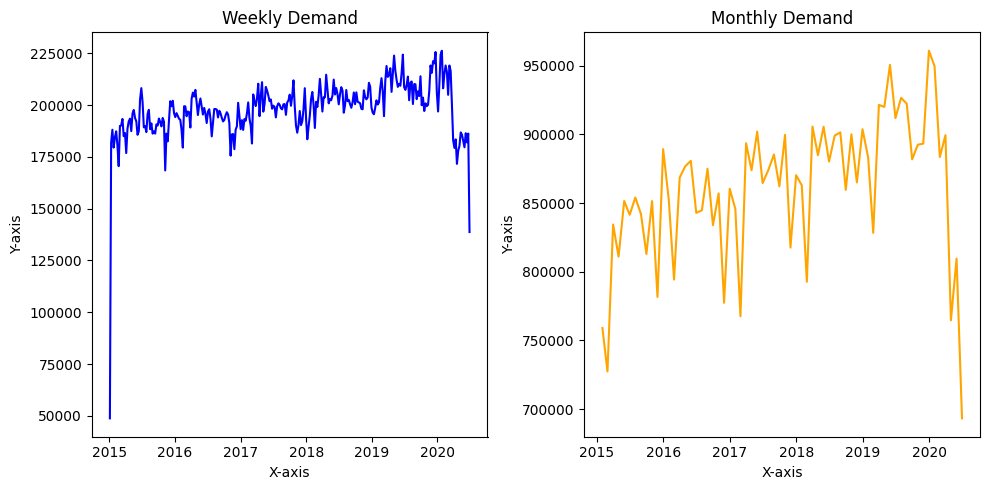

In [9]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot on the first subplot
axs[0].plot(df_weekly, color='blue')
axs[0].set_title('Weekly Demand')
axs[0].set_xlabel('X-axis')
axs[0].set_ylabel('Y-axis')

# Plot on the second subplot
axs[1].plot(df_monthly, color='orange')
axs[1].set_title('Monthly Demand')
axs[1].set_xlabel('X-axis')
axs[1].set_ylabel('Y-axis')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

Remove covid lockdown anomaly entries

In [10]:
df_weekly = df_weekly[1:273]
df_weekly.tail

<bound method NDFrame.tail of datetime
2015-01-11    181919.6224
2015-01-18    188082.3152
2015-01-25    179448.7184
2015-02-01    184393.4256
2015-02-08    187290.1846
                 ...     
2020-02-23    216005.1882
2020-03-01    204924.9816
2020-03-08    219065.4724
2020-03-15    216436.7037
2020-03-22    200434.6963
Freq: W-SUN, Name: nat_demand, Length: 272, dtype: float64>

In [11]:
df_monthly = df_monthly[1:63]
df_monthly.tail

<bound method NDFrame.tail of datetime
2015-02-28    727459.6830
2015-03-31    834460.6436
2015-04-30    811015.6093
2015-05-31    851568.1301
2015-06-30    841533.2228
                 ...     
2019-11-30    893320.6349
2019-12-31    960994.8755
2020-01-31    949784.6787
2020-02-29    883585.6166
2020-03-31    899489.8138
Freq: ME, Name: nat_demand, Length: 62, dtype: float64>

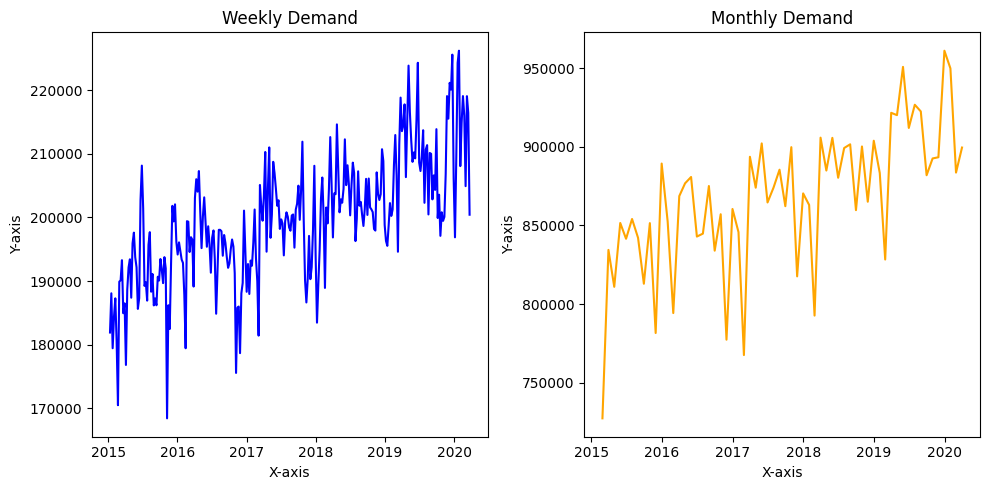

In [12]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot on the first subplot
axs[0].plot(df_weekly, color='blue')
axs[0].set_title('Weekly Demand')
axs[0].set_xlabel('X-axis')
axs[0].set_ylabel('Y-axis')

# Plot on the second subplot
axs[1].plot(df_monthly, color='orange')
axs[1].set_title('Monthly Demand')
axs[1].set_xlabel('X-axis')
axs[1].set_ylabel('Y-axis')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Predicting from 2019/3/24 - 2020/3/22

In [13]:
df_train_weekly = df_weekly[1:217]
df_test_weekly = df_weekly[217:273]
df_train_monthly = df_monthly[1:49]
df_test_monthly = df_monthly[49:63]

## Check for stationary behavior


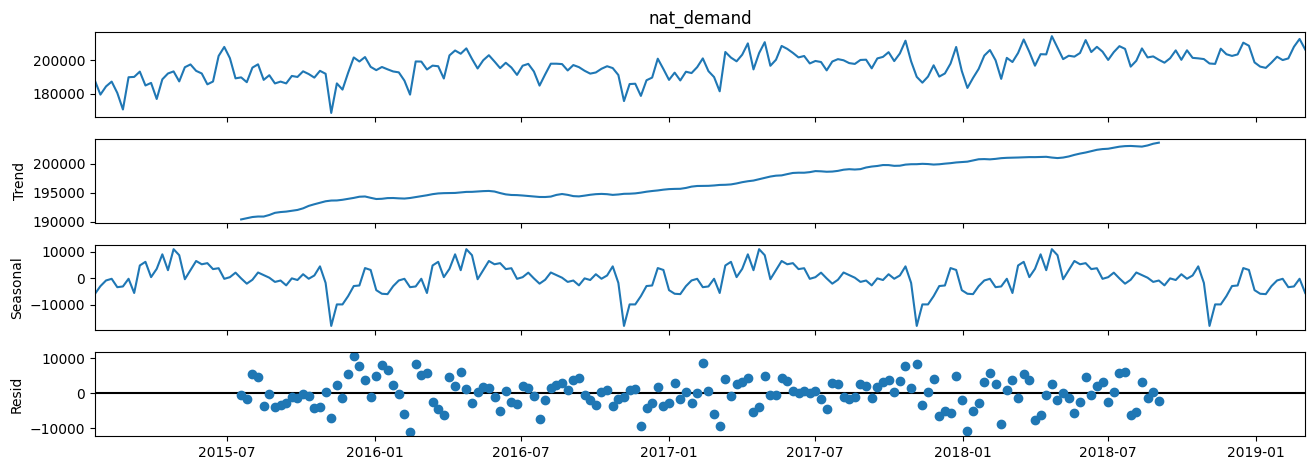

In [14]:
decomp_weekly = sm.tsa.seasonal_decompose(df_train_weekly, model='additive')
fig = decomp_weekly.plot()
fig.set_figwidth(15)

In [15]:
adf_weekly = adfuller(df_train_weekly)
print(f'adfuller test P-value: {adf_weekly[1]}')

adfuller test P-value: 0.017908029651821523


**P-value is less than 0.05, therfore we reject the null hypothesis & series is statistically significant. Hence, series is stationary**

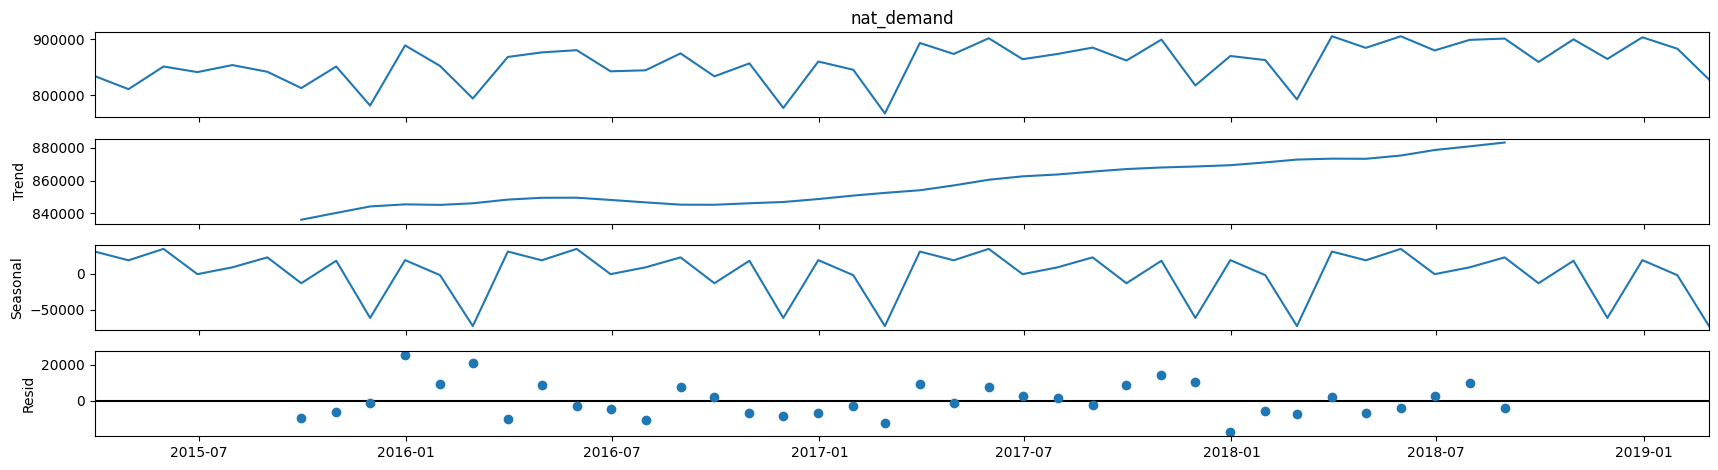

In [16]:
decomp_monthly = sm.tsa.seasonal_decompose(df_train_monthly, model='additive')
fig2 = decomp_monthly.plot()
fig2.set_figwidth(20)

In [17]:
adf_monthly = adfuller(df_train_monthly)
print(f'adfuller test P-value: {adf_monthly[1]}')

adfuller test P-value: 0.37932694007806605


**P-value is higher than 0.05, therfore the null hypothesis holds. Hence, series is not stationary**

## ARIMA

### Manual Hyperparameters Tuning

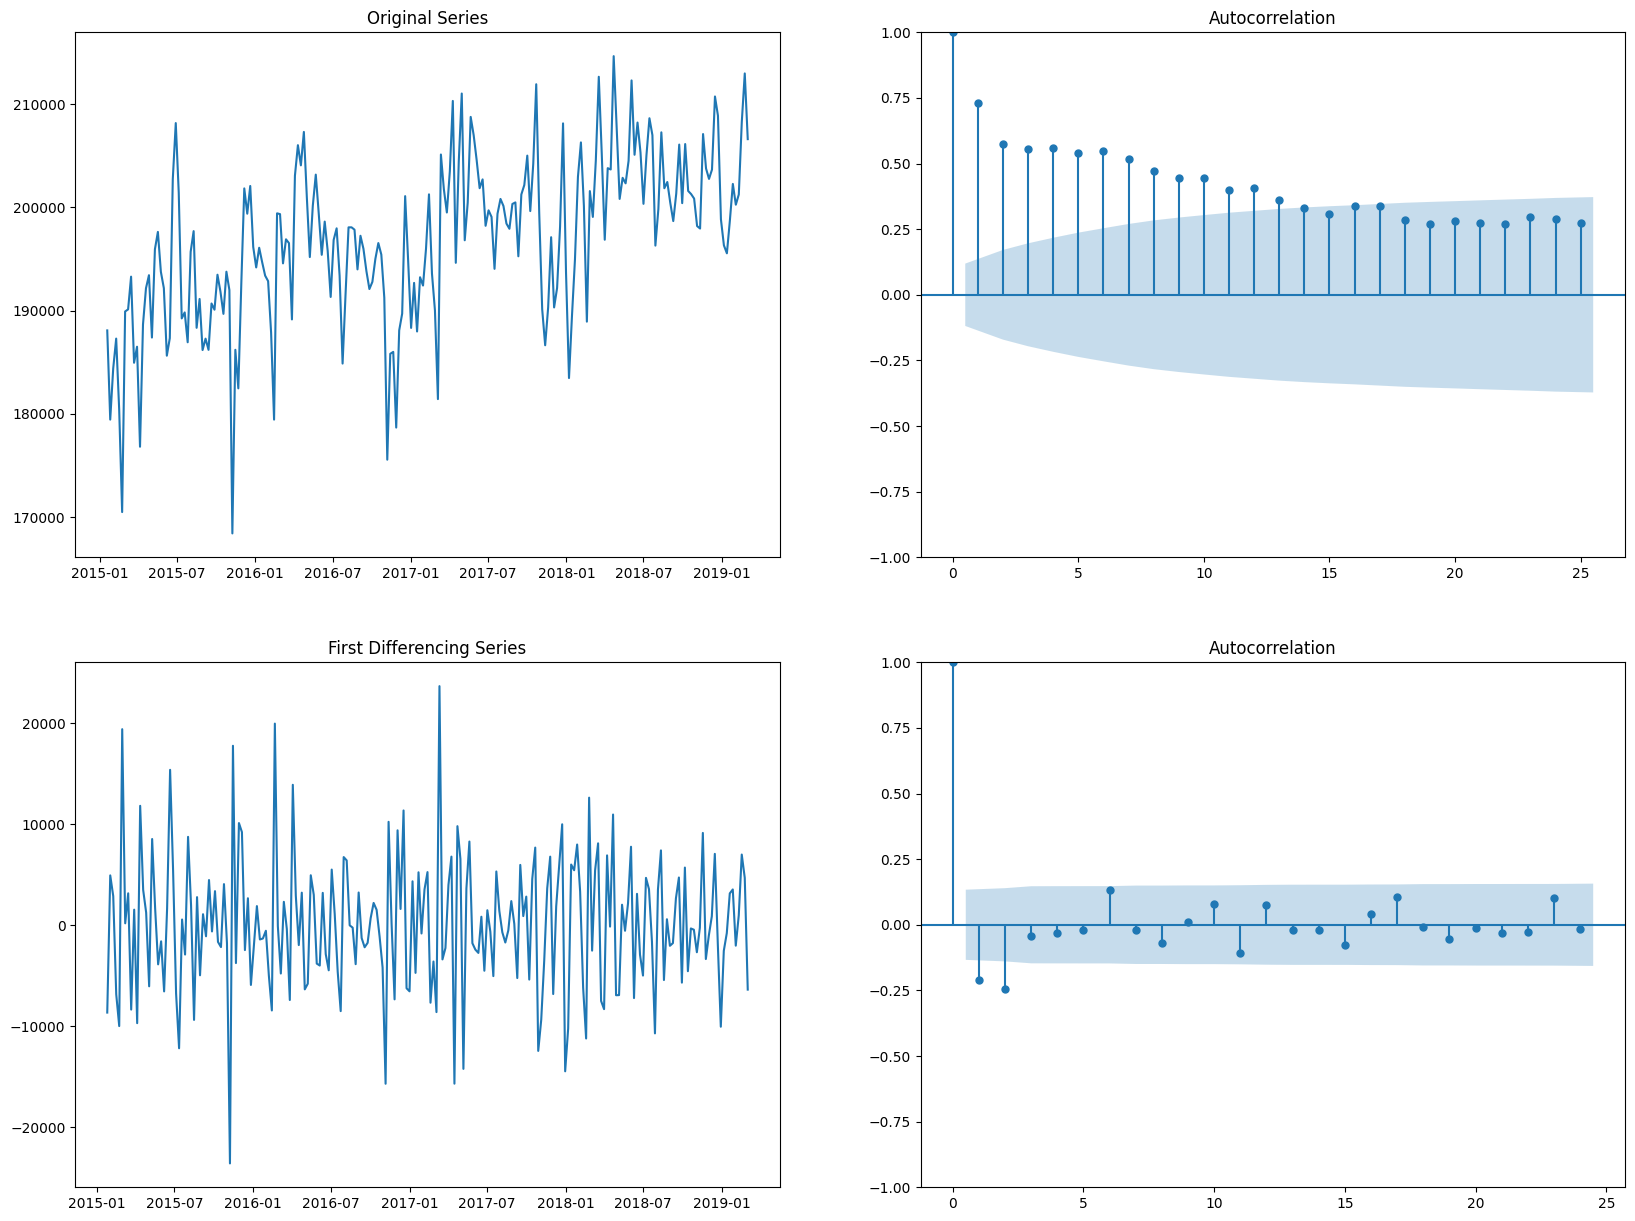

In [18]:
fig, axes = plt.subplots(2, 2, figsize = (20, 15))
axes[0, 0].plot(df_train_weekly)
axes[0, 0].set_title('Original Series')
plot_acf(df_weekly, ax=axes[0,1])
axes[1, 0].plot(df_train_weekly.diff())
axes[1, 0].set_title('First Differencing Series')
plot_acf(df_train_weekly.diff().dropna(), ax=axes[1,1])
plt.show()

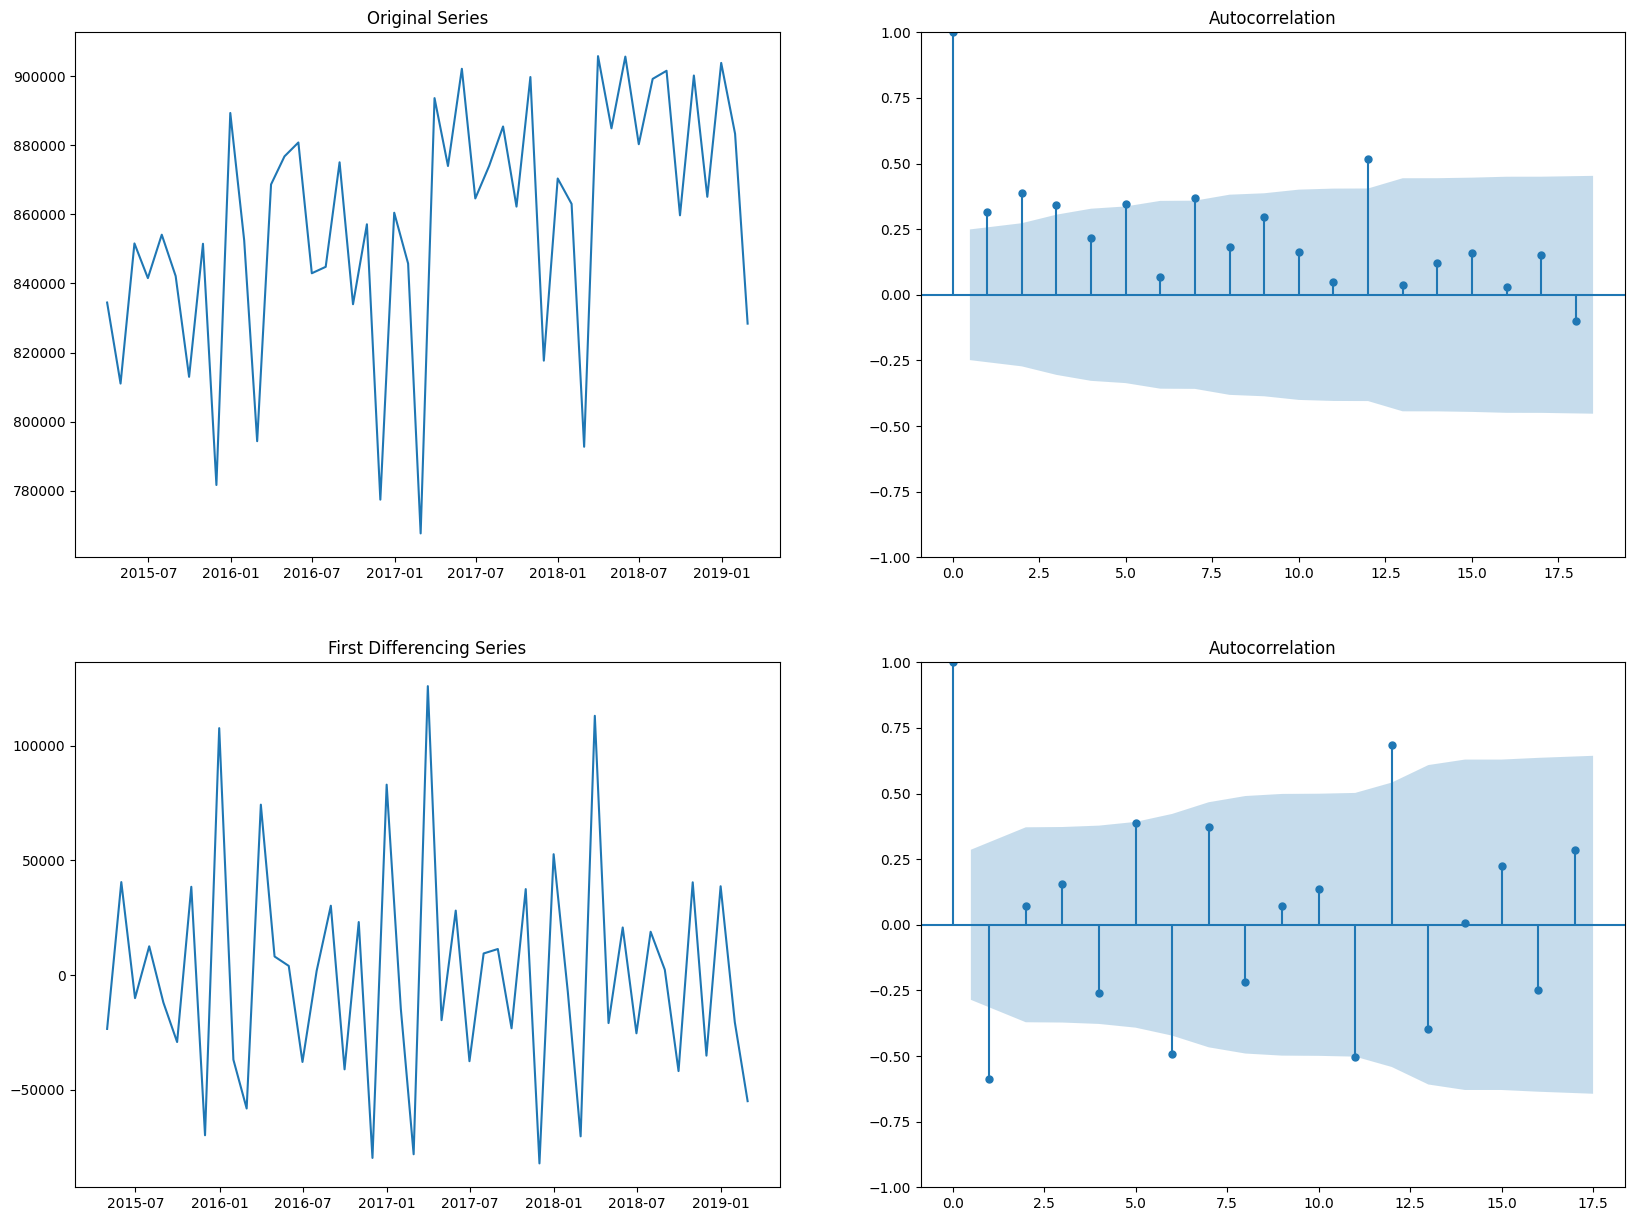

In [19]:
fig, axes = plt.subplots(2, 2, figsize = (20, 15))
axes[0, 0].plot(df_train_monthly)
axes[0, 0].set_title('Original Series')
plot_acf(df_monthly, ax=axes[0,1])
axes[1, 0].plot(df_train_monthly.diff())
axes[1, 0].set_title('First Differencing Series')
plot_acf(df_train_monthly.diff().dropna(), ax=axes[1,1])
plt.show()

**ADF test is aligned with the weekly data, so set order of differencing(d) to 0**

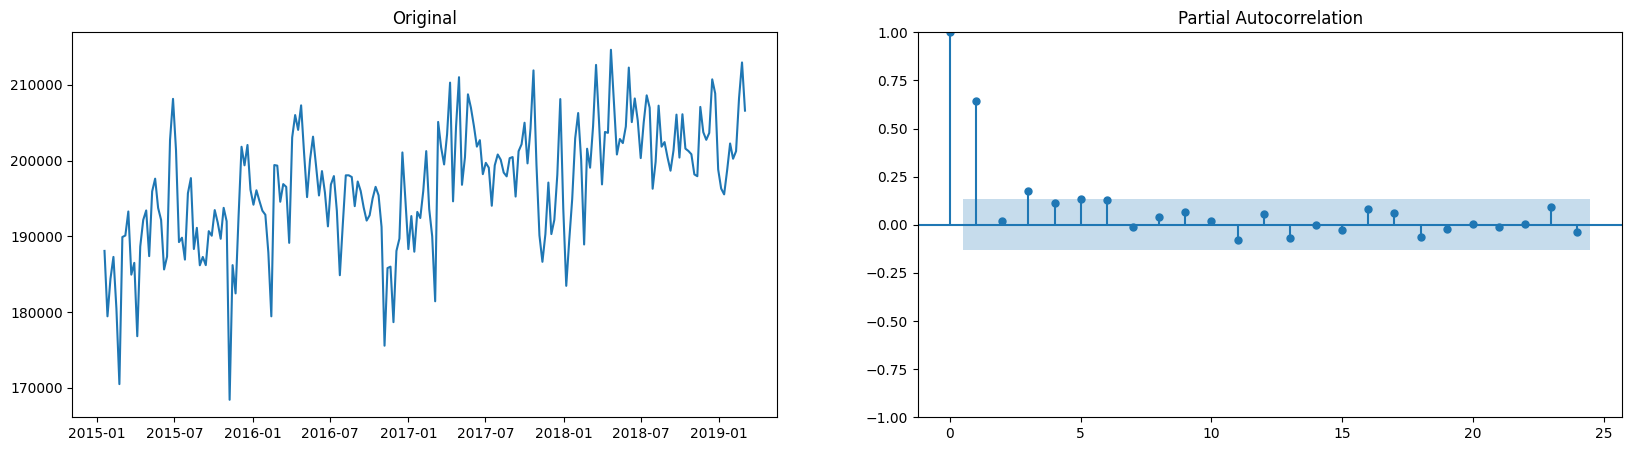

In [20]:
fig, axes = plt.subplots(1, 2, figsize = (20, 5))
axes[0].plot(df_train_weekly)
axes[0].set_title('Original')
plot_pacf(df_train_weekly, ax=axes[1])

plt.show()

**PACF lag 1 is above limit, so choose AR term (p) to be 1**

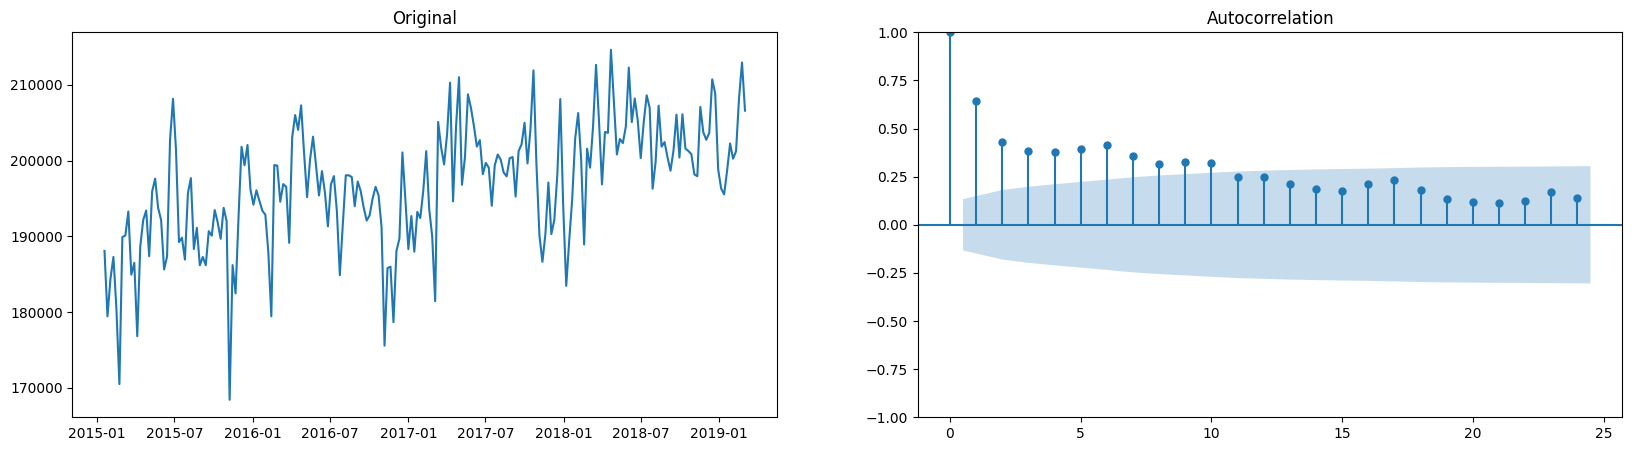

In [21]:
fig, axes = plt.subplots(1, 2, figsize = (20, 5))
axes[0].plot(df_train_weekly)
axes[0].set_title('Original')
plot_acf(df_train_weekly, ax=axes[1])

plt.show()

**From ACF lag, we would choose the number of terms that are significantly above the limit to keep model simple, so choose MA term (q) to be 2**

## Train Model

In [22]:
model = ARIMA(df_train_weekly, exog = None, order = (1,0,2)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             nat_demand   No. Observations:                  216
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -2178.013
Date:                Fri, 19 Jul 2024   AIC                           4366.027
Time:                        07:19:09   BIC                           4382.903
Sample:                    01-18-2015   HQIC                          4372.845
                         - 03-03-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.968e+05   3598.210     54.688      0.000     1.9e+05    2.04e+05
ar.L1          0.9736      0.024     41.176      0.000       0.927       1.020
ma.L1         -0.4291      0.068     -6.354      0.000      -0.561      -0.297
ma.L2         -0.3242      0.068     -4.741      0.000      -0.458      -0.190
sigma2      3.236e+07      0.149   2.17e+08      0.000    3.24e+07    3.24e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                13.71
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                            -0.24
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.08e+27. Standard errors may be unstable.
"""

## Model Evaluation

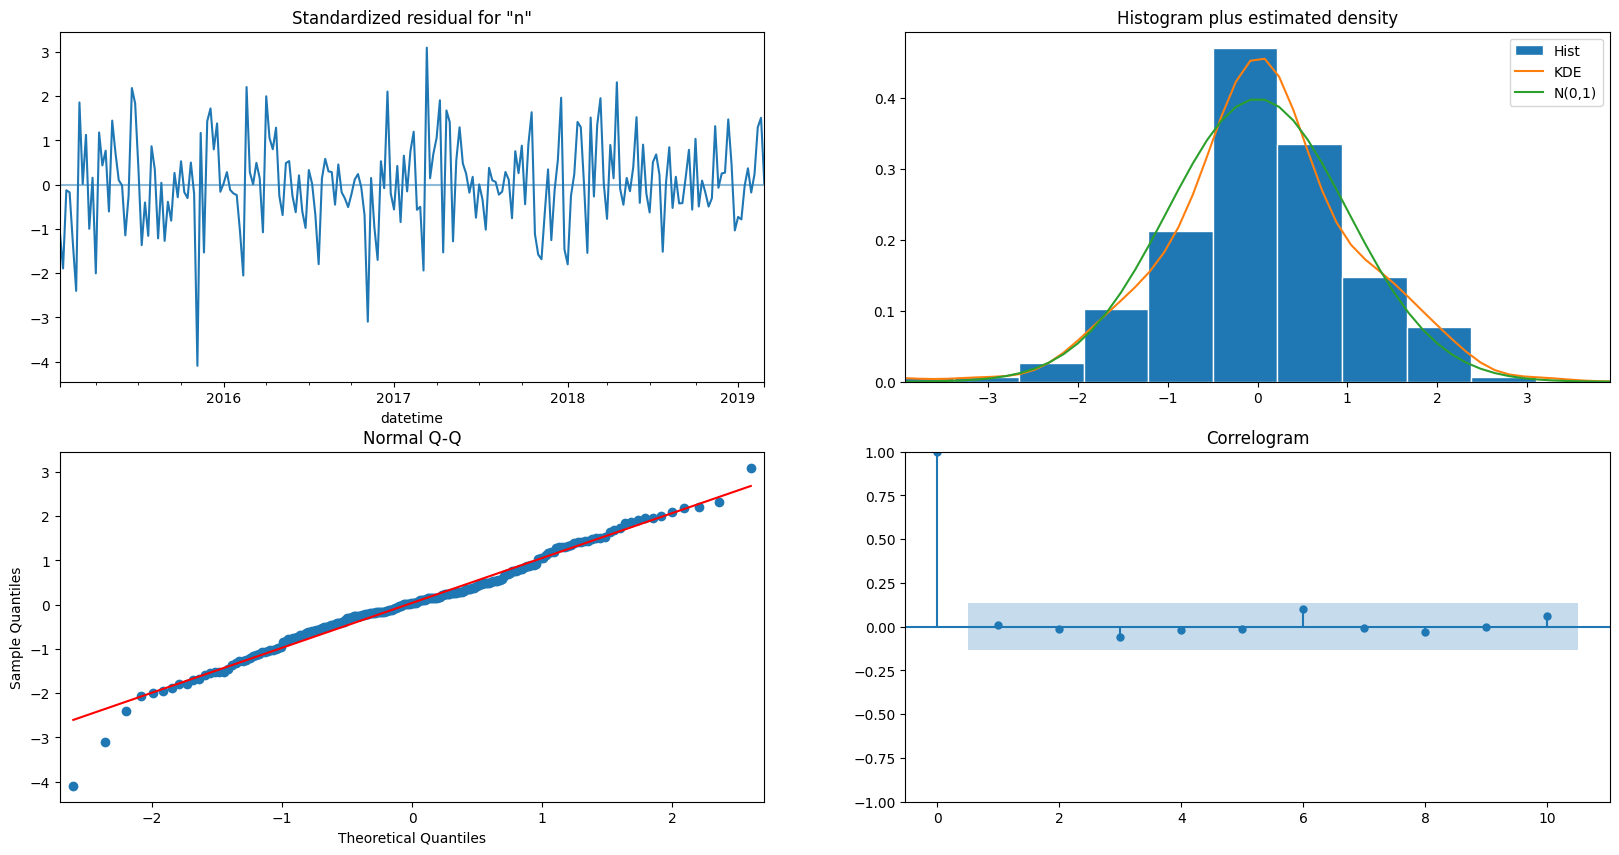

In [23]:
model.plot_diagnostics(figsize=(20,10))
plt.show()

## Predict Test Dataset

In [24]:
pred = model.predict(start = len(df_train_weekly), end = len(df_weekly)-2)
print("RMSE: "+ str(np.sqrt(mean_squared_error(df_test_weekly, pred))))

RMSE: 13221.795717211586


<Axes: xlabel='datetime'>

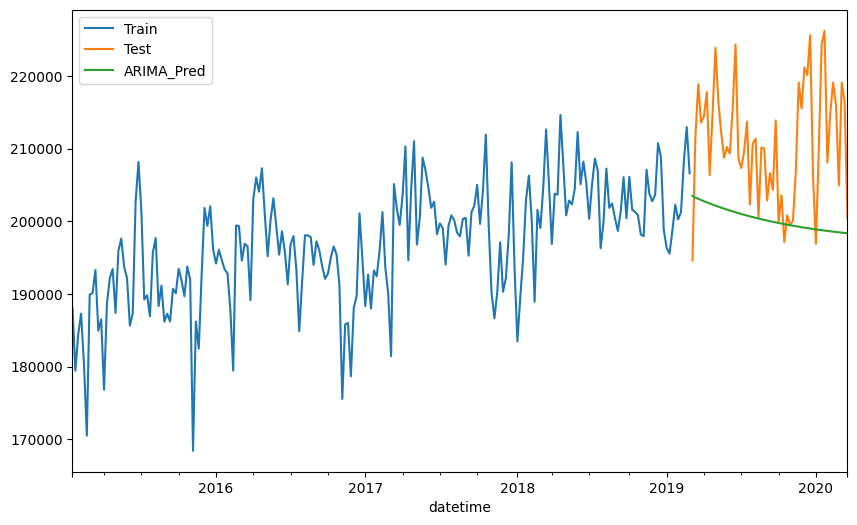

In [25]:
df_train_weekly.plot(legend = True, label = 'Train', figsize=(10, 6))
df_test_weekly.plot(legend = True, label = 'Test')
pred.plot(legend = True, label = 'ARIMA_Pred')

## Auto ARIMA/SARIMA

### Train Model

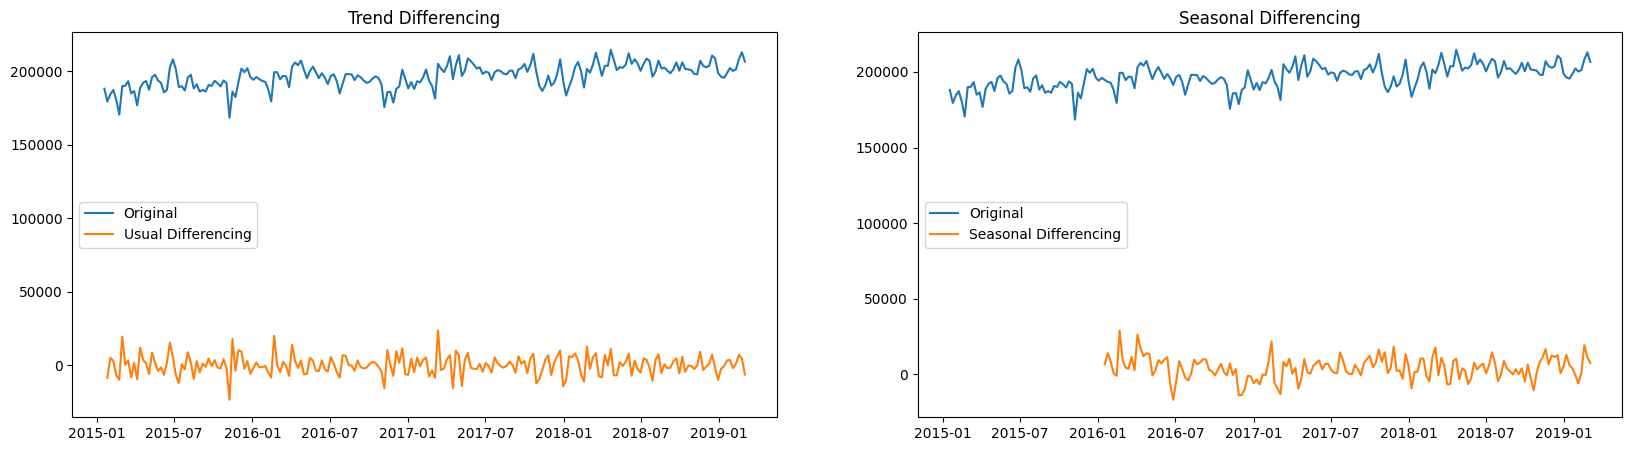

In [26]:
fig, axes = plt.subplots(1, 2, figsize = (20,5))
axes[0].plot(df_train_weekly, label = 'Original')
axes[0].plot(df_train_weekly.diff(1), label = 'Usual Differencing')
axes[0].set_title('Trend Differencing')
axes[0].legend(loc='center left', fontsize=10)
axes[1].plot(df_train_weekly, label = 'Original')
axes[1].plot(df_train_weekly.diff(52), label = 'Seasonal Differencing')
axes[1].set_title("Seasonal Differencing")
axes[1].legend(loc='center left', fontsize=10)
plt.show()


**There is no proof of seasonality in this series**

In [27]:
arima = auto_arima(df_train_weekly, trace=True, error_action='ignore', test = 'adf', start_p=1, start_q=1, max_p=10, max_q=10, m=1, D=0, suppress_warnings=True, stepwise=True, seasonal=False)
arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4395.208, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5881.344, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5727.225, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4429.397, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4372.328, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5693.253, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=4374.850, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=5686.043, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4378.980, Time=0.12 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 1.271 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  216
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -2182.164
Date:                Fri, 19 Jul 2024   AIC                           4372.328
Time:                        07:19:12   BIC                           4385.829
Sample:                    01-18-2015   HQIC                          4377.782
                         - 03-03-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   3353.567      0.000       0.999       1.001
ma.L1         -0.4535      0.058     -7.829      0.000      -0.567      -0.340
ma.L2         -0.3427      0.063     -5.413      0.000      -0.467      -0.219
sigma2      3.371e+07   5.82e-11   5.79e+17      0.000    3.37e+07    3.37e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                10.31
Prob(Q):                              0.98   Prob(JB):                         0.01
Heteroskedasticity (H):               0.67   Skew:                            -0.13
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.3e+34. Standard errors may be unstable.
"""

## Model Evaluation

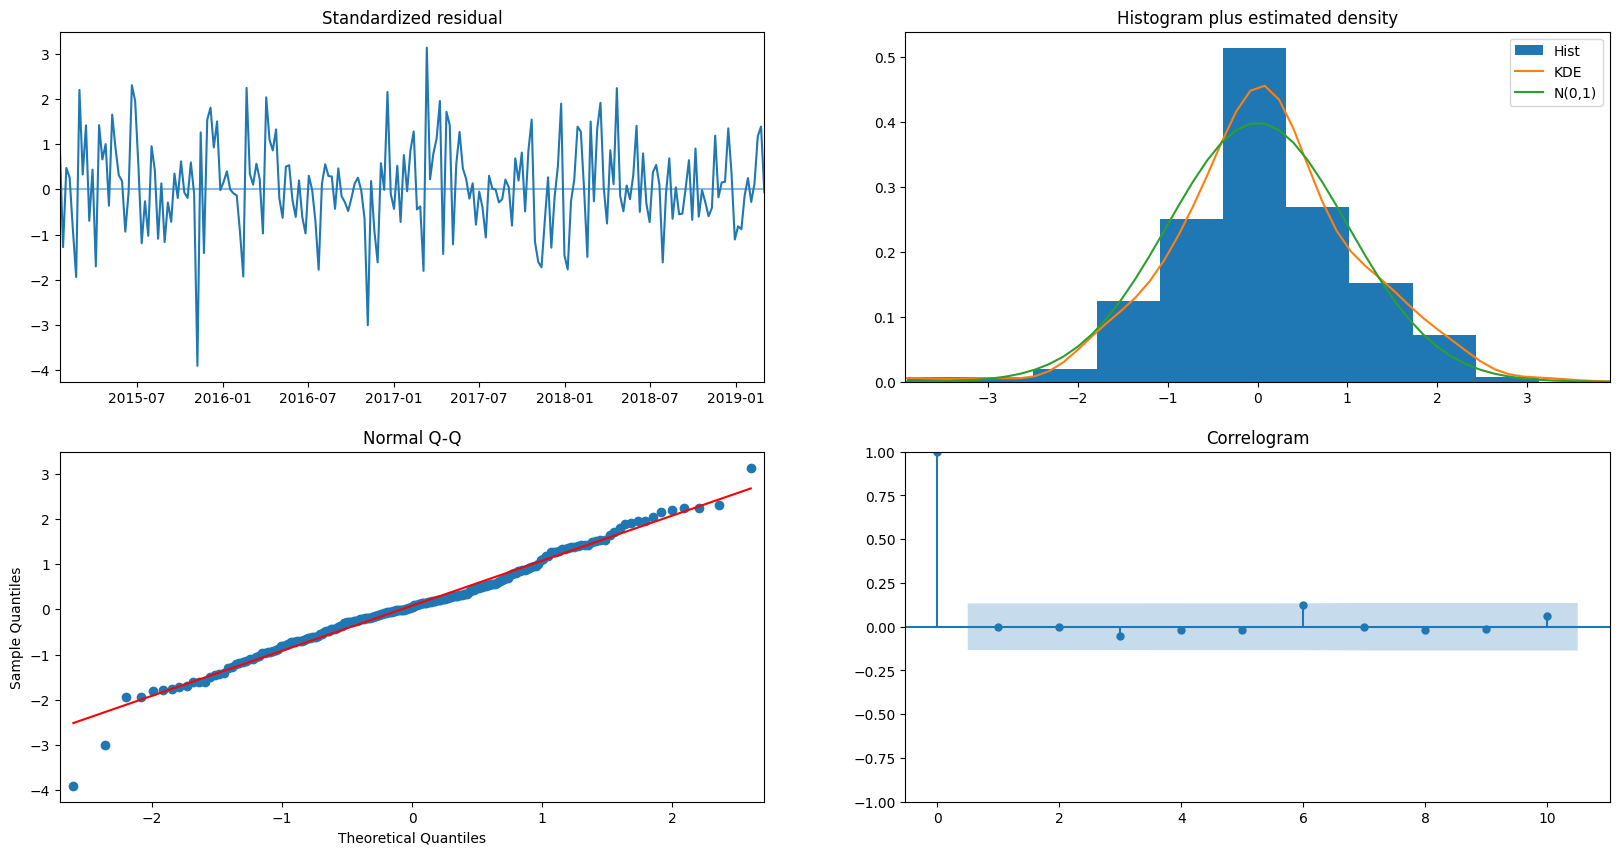

In [28]:
arima.plot_diagnostics(figsize=(20,10))
plt.show()

In [29]:
print("RMSE: "+ str(np.sqrt(mean_squared_error(df_test_weekly, pred))))

RMSE: 13221.795717211586


## Predict Test Dataset

<Axes: xlabel='datetime'>

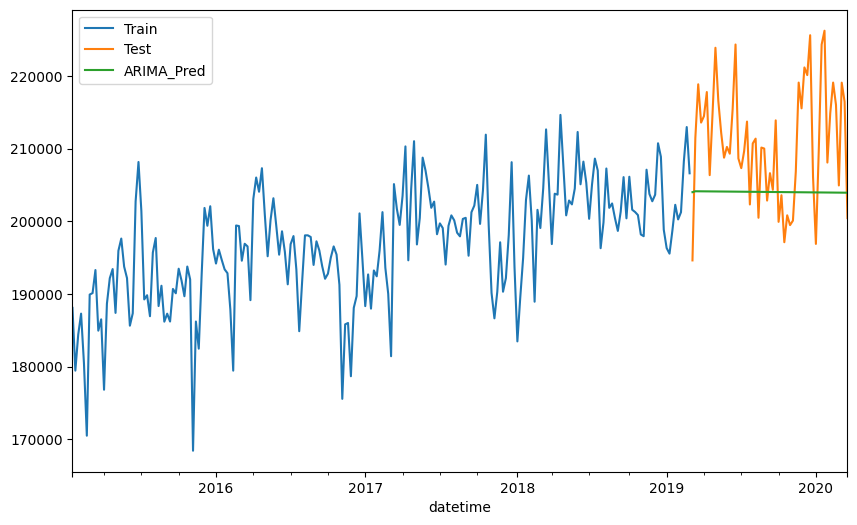

In [30]:
pred = arima.predict(n_periods = len(df_test_weekly))
df_train_weekly.plot(legend = True, label = 'Train', figsize=(10, 6))
df_test_weekly.plot(legend = True, label = 'Test')
pred.plot(legend = True, label = 'ARIMA_Pred')

**This is a good improvement compared to the previous model**

## Auto ARIMA with Exogeneous variables

In [31]:
df_exo = df.resample('W').sum().iloc[:, 1:]
exo_train = df_exo[2:218]
exo_test = df_exo[218:273]

## Include only those exogenous variables that are significant

In [32]:
arimax = auto_arima(df_train_weekly, trace=True, X = exo_train[['T2M_toc', 'TQL_toc', 'QV2M_san', 'QV2M_dav', 'holiday']], error_action='ignore', test = 'adf', approximation=False, start_p=0, start_q=0, max_p=10, max_q=10, m=1, D=0, suppress_warnings=True, stepwise=True, seasonal=False)
arimax.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5407.751, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4244.157, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4343.497, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4234.635, Time=0.19 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4226.966, Time=0.43 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=4223.960, Time=0.50 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=4220.679, Time=0.62 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=4222.841, Time=0.46 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=4217.484, Time=0.68 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=4215.947, Time=0.55 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4214.854, Time=0.31 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4212.548, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4220.828, Time=0.16 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4214.144, Time=0.52 sec
 ARIMA(1,0,2)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  216
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -2097.274
Date:                Fri, 19 Jul 2024   AIC                           4212.548
Time:                        07:19:21   BIC                           4242.925
Sample:                    01-18-2015   HQIC                          4224.820
                         - 03-03-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T2M_toc       43.2142      2.410     17.929      0.000      38.490      47.938
TQL_toc     -342.0582     68.963     -4.960      0.000    -477.223    -206.893
QV2M_san    4.463e+04   6441.612      6.928      0.000     3.2e+04    5.73e+04
QV2M_dav   -4.646e+04   7941.375     -5.850      0.000    -6.2e+04   -3.09e+04
holiday     -149.8974     12.500    -11.992      0.000    -174.397    -125.397
ar.L1          1.3634      0.091     14.939      0.000       1.185       1.542
ar.L2         -0.3657      0.090     -4.075      0.000      -0.542      -0.190
ma.L1         -0.8882      0.055    -16.099      0.000      -0.996      -0.780
sigma2      1.688e+07     18.522   9.11e+05      0.000    1.69e+07    1.69e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 1.39
Prob(Q):                              0.82   Prob(JB):                         0.50
Heteroskedasticity (H):               1.29   Skew:                             0.11
Prob(H) (two-sided):                  0.28   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.33e+25. Standard errors may be unstable.
"""

<Axes: xlabel='datetime'>

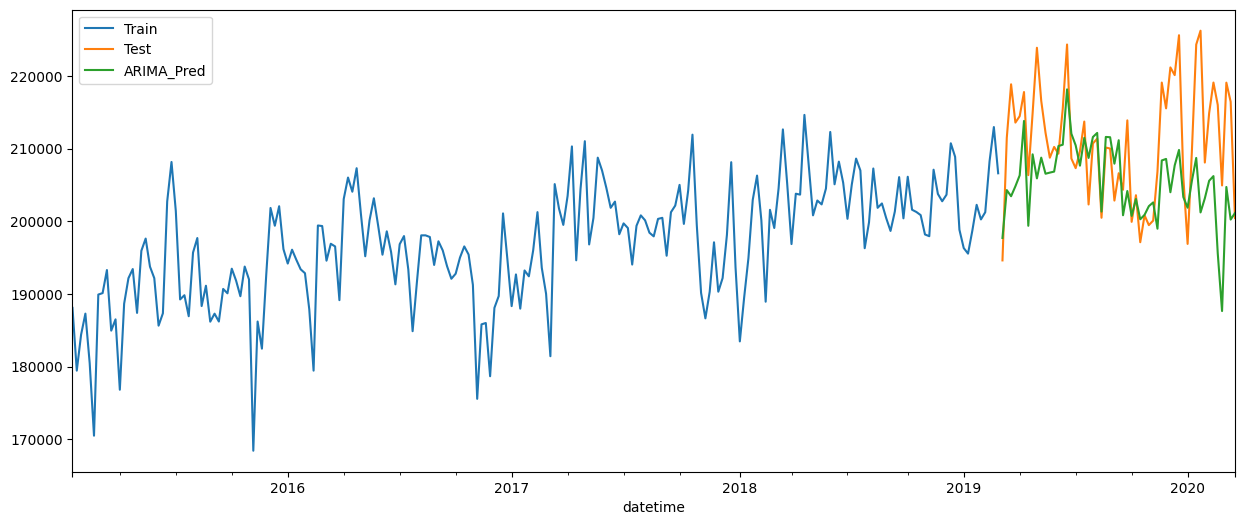

In [33]:
pred_x = arimax.predict(n_periods = len(df_test_weekly), X = exo_test[['T2M_toc', 'TQL_toc', 'QV2M_san', 'QV2M_dav', 'holiday']])
df_train_weekly.plot(legend = True, label = 'Train', figsize=(15,6))
df_test_weekly.plot(legend = True, label = 'Test')
pred_x.plot(legend = True, label = 'ARIMA_Pred')

In [34]:
print('RMSE: '+ str(np.sqrt(mean_squared_error(df_test_weekly, pred_x))))

RMSE: 9135.53822720682


## Include all exogenous variables available

In [35]:
arimax = auto_arima(df_train_weekly, trace=True, X=exo_train, error_action='ignore', test='adf', approximation=False, start_p=0, start_q=0, max_p=10, max_q=10, m=1, D=0, suppress_warnings=True, stepwise=True, seasonal=False)
arimax.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5403.350, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4259.566, Time=0.43 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4367.947, Time=0.43 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4238.640, Time=0.51 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4233.108, Time=0.57 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=4234.670, Time=0.91 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4223.390, Time=0.66 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4219.592, Time=0.51 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4223.827, Time=0.48 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4220.487, Time=0.61 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4219.469, Time=0.52 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4341.363, Time=0.56 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=4222.373, Time=1.11 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=4327.899, Time=1.35 sec
 ARIMA(2,0,3)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  216
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -2090.735
Date:                Fri, 19 Jul 2024   AIC                           4219.469
Time:                        07:19:32   BIC                           4283.600
Sample:                    01-18-2015   HQIC                          4245.378
                         - 03-03-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T2M_toc       28.7057     10.210      2.812      0.005       8.695      48.717
QV2M_toc   -5881.2743   9132.774     -0.644      0.520   -2.38e+04     1.2e+04
TQL_toc     -454.3384    140.474     -3.234      0.001    -729.663    -179.014
W2M_toc        1.0550      1.387      0.761      0.447      -1.663       3.773
T2M_san       -2.4029      9.509     -0.253      0.800     -21.040      16.234
QV2M_san    3.651e+04   1.12e+04      3.259      0.001    1.46e+04    5.85e+04
TQL_san     -175.7113    124.808     -1.408      0.159    -420.330      68.908
W2M_san        3.0283      2.826      1.071      0.284      -2.511       8.568
T2M_dav       16.3045     12.847      1.269      0.204      -8.874      41.483
QV2M_dav   -3.169e+04   1.11e+04     -2.851      0.004   -5.35e+04   -9904.940
TQL_dav      356.1380     93.803      3.797      0.000     172.287     539.989
W2M_dav       -6.9267      5.283     -1.311      0.190     -17.282       3.428
Holiday_ID     1.5150      2.752      0.550      0.582      -3.880       6.910
holiday     -171.1481     33.146     -5.164      0.000    -236.112    -106.184
school         6.0319      6.928      0.871      0.384      -7.546      19.610
ar.L1          0.9984      0.006    169.241      0.000       0.987       1.010
ma.L1         -0.6524      0.092     -7.058      0.000      -0.834      -0.471
ma.L2         -0.1771      0.092     -1.915      0.056      -0.358       0.004
sigma2       1.76e+07     24.940   7.06e+05      0.000    1.76e+07    1.76e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.82
Prob(Q):                              0.95   Prob(JB):                         0.66
Heteroskedasticity (H):               1.40   Skew:                            -0.02
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.01e+21. Standard errors may be unstable.
"""

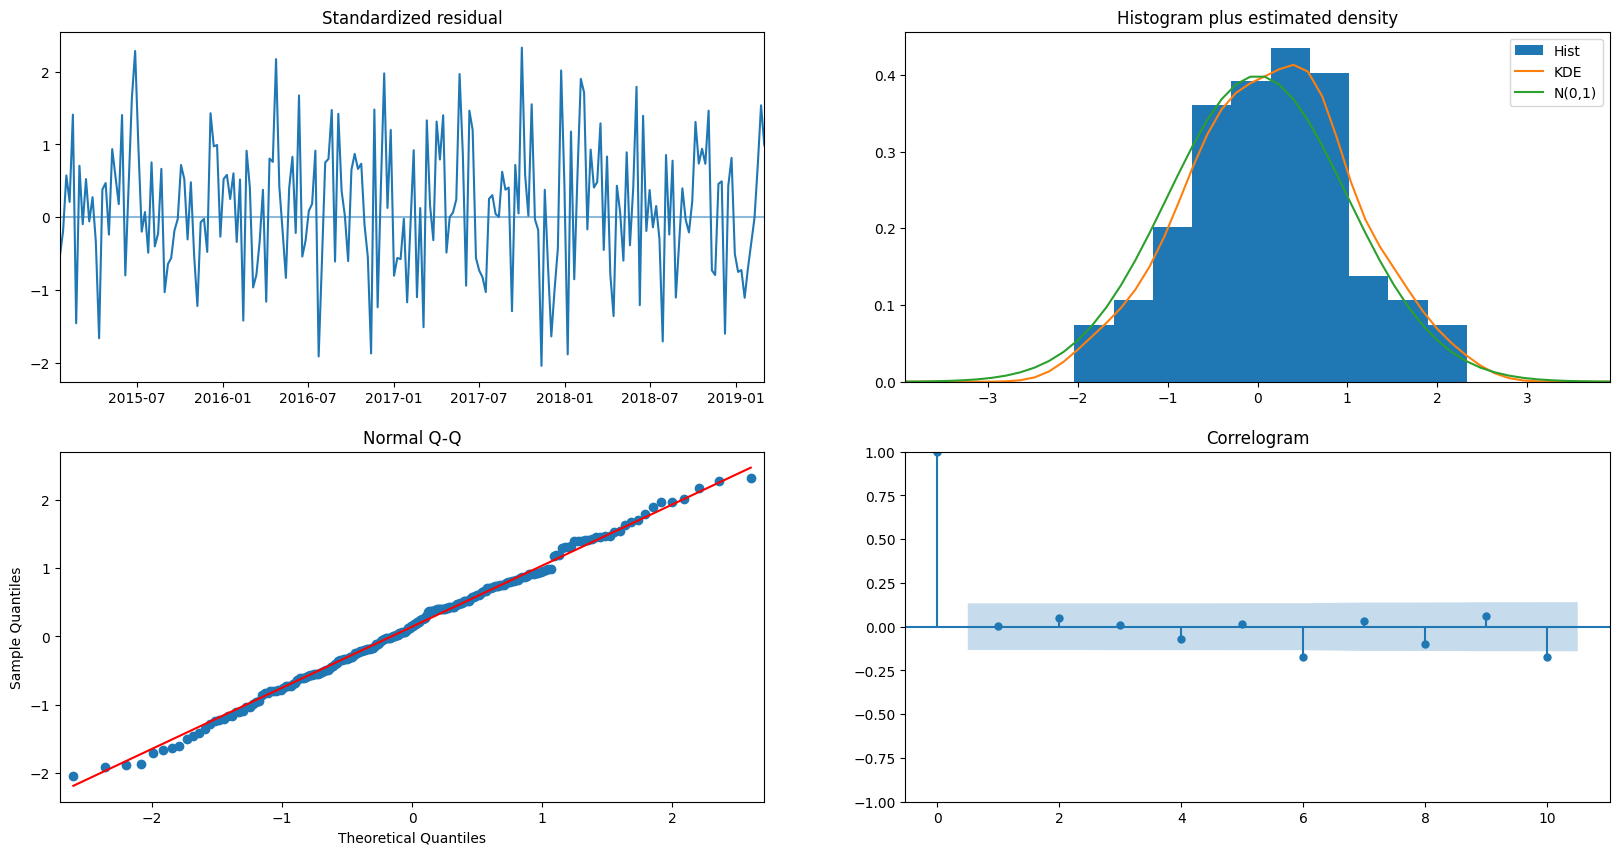

In [36]:
arimax.plot_diagnostics(figsize=(20,10))
plt.show()

**In Normal Q-Q plot, most dots fall perfectly in line with the red line compared to previous results**

<Axes: xlabel='datetime'>

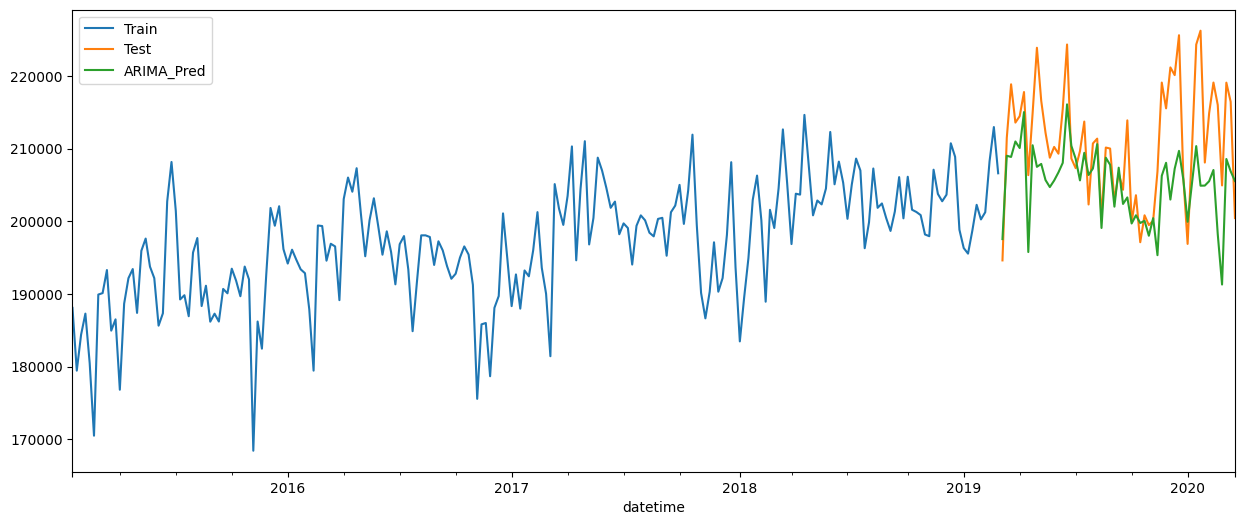

In [37]:
pred_x = arimax.predict(n_periods = len(df_test_weekly), X = exo_test)
df_train_weekly.plot(legend = True, label = 'Train', figsize=(15,6))
df_test_weekly.plot(legend = True, label = 'Test')
pred_x.plot(legend = True, label = 'ARIMA_Pred')

In [38]:
print("RMSE: "+ str(np.sqrt(mean_squared_error(df_test_weekly, pred_x))))

RMSE: 8311.883897879035


**This is best model we have so far, we can improve our model further by applying data processing for exogeneous variables**